<a href="https://colab.research.google.com/github/ninadcpa/DSC540/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSC540 - Data Wrangling - Final Project

## Title - Public Justice System Expenditures and Crime Control effectiveness across US States

@author Ninad Patkhedkar  
@guide  Catherine Williams

Term - Spring 2021  
Bellevue Univeristy 

---



# Milesstone 1

# Introduction
> Effective Law and Order is one of the most important necessity of society. It has direct effect on living standard and crime rate in that area. The whole "Law and Order" aka Justice system consists of multiple functions which performs duties as below   

> **Police Protection Services** - law enforcement, patrolling, traffic safety, parking meter read, animal warden etc. 

> **Judicial and Legal Services** - civil and criminal functions of courts, state’s attorneys, court reporters, register of wills etc. 

> **Correction Services** - prisons, reformatories, rehabilitation centers, parole boards, pardon boards etc. 

> To effectively govern any area, all these functions need resources i.e. people to perform duties and funding.

In this project I will use public dataset about state wise employment and expenditures on various functions. I will also correlate state wise crime during same period. I will investigate and find more information about how effectively Justice and Legal system is managed in different states.  I will also try to find any correlation between population of state, expenses and number of employees etc. 

I will use 3 different sources of data 

# Dataset Sources  

1. **Flat file**  - jeee16t03.csv
Public dataset for fiscal 2016 from Bureau of Justice Statistics on Justice Expenditure - https://www.bjs.gov/content/pub/sheets/jeee16p.zip 

2. **Web Site**  
Public dataset on Crime for fiscal 2016 from FBI - https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/tables/table-3

3. **API** 
Public dataset for fiscal 2016 from Bureau of Justice Statistics on Employee Extracts - https://data.world/usbjs/justice-expenditure-and-employment-2016/workspace/file?filename=jeee16t08.csv

API Data is from same source as #1 i.e. Bureau of Justice Statistics. As requiremnet is to fetch data over API, the dataset is maintained on ***data.world***  and will be fetched in json form using ***requests*** library.



```
# sample linux command to fetch data in json format
curl --request POST \
  --url "https://api.data.world/v0/sql/ninadcpa/dsc540?includeTableSchema=true" \
  --header "Authorization: Bearer <api_token>" \
  --header "Accept: application/json" \
  --data-urlencode 'query=SELECT * FROM jeee16t08'
```

For Definitions, Methodology and other information, refer detailed guide -  
https://www.bjs.gov/content/pub/pdf/jeeeguide.pdf  
https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/tables/table-3/table-3-data-declaration.pdf

# Data Prep

All 3 datasets have common key of State name. It has one-to-one relationship across all 3 datasets.
 
I will cleanup each data set and and create a consolidated dataset by "State" in this section. Here are few things I will perform as part of cleanup   

* **Simplify column names by converting to lower case and spaces replaced by underscores**
* **Rename long column names to short names e.g. population_2016_thousands to population_k**
* **Remove records of Total federal govt, Local city govt, Municipality govt data and keep only State data**
* **Remove records where population is not present**
* **Trim State abbreviations from records i.e. Virginia (VA) -> Virginia** 
* **Join Datasets by using "State" as common key**
  
# Objective
As part of this Project, I will try to find answer following questions​
1. How state population affects overall cost and per capita cost?
2. How number of employees in police protection services affect the cost of police protection? 
3. How number of employees in judicial and legal services affect the cost of judicial and legal functions?
4. How number of employees in correction services affect the cost of correction functions?
5. Which states are doing great job with overall crime control?
6. What is relation between number of employees in police protection services and crime in the area?


In [1]:
# This code is written for mounting code folder checked out from github on google drive
# All project code will be maintained inside folder "DSC540"

from google.colab import drive
import sys
import os

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/DSC540')
os.chdir('/content/drive/MyDrive/Colab Notebooks/DSC540')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Milestone 2

Cleaning/Formatting Flat File Source
Perform at least 5 data transformation and/or cleansing steps to your flat file data. For example:

> Replace Headers  
Format data into a more readable format  
Identify outliers and bad data  
Find duplicates  
Fix casing or inconsistent values  
Conduct Fuzzy Matching

---

I am using flat file in csv format "jeee16t03.csv" 

Lets load the file data in panda dataframe and check some records

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Reading csv file into panda dataframe
df_jee03 = pd.read_csv("jeee16t03.csv")
df_jee03.head(10)

,State and type of government,Population 2016 thousands,Total direct expenditure,total justice system Amount,total justice system percent,Police protection Amount,police protection Percent,judician and legal Amount,judicial and legal Percent,corrections Amount,corrections Percent
0,"States-local, total",323071,3514583394,233483760,6.6,109210078,46.8,46256957,19.8,78016725,33.4
1,State,-,1692408177,86868791,5.1,15003016,17.3,22825679,26.3,49040096,56.5
2,"Local, total",-,1822175217,146614969,8.0,94207062,64.3,23431278,16.0,28976629,19.8
3,Counties,-,394148057,71684805,18.2,29596808,41.3,17767223,24.8,24320774,33.9
4,Municipalities,-,583324970,69058355,11.8,59702889,86.5,5274743,7.6,4080723,5.9
5,Alabama (AL),4865,45277563,2335599,5.2,1251270,53.6,362060,15.5,722269,30.9
6,AL State,-,23075269,870057,3.8,165168,19.0,200146,23.0,504743,58.0
7,"AL Local, total",-,22202294,1465542,6.6,1086102,74.1,161914,11.0,217526,14.8
8,AL Counties,-,2244358,644571,28.7,358334,55.6,90688,14.1,195549,30.3
9,AL Municipalities,-,6596181,820971,12.4,727768,88.6,71226,8.7,21977,2.7


In [3]:
df_jee03.shape

(256, 11)

Data contains 256 observationas and 11 variables.  
Dataset contains records for fedral, state, local governments, muncipalties and counties. 

For this project, as state is common key field for all 3 datasets. Hence I will try to filter records only at state level.

I will perform as part of cleanup  

* **Simplify column names by converting to lower case and spaces replaced by underscores**
* **Rename long column names to short names e.g. population_2016_thousands to population_k**
* **Remove records of Total federal govt, Local city govt, Municipality govt data and keep only State data**
* **Remove records where population is not present**
* **Trim State abbreviations from records i.e. Virginia (VA) -> Virginia** 

In [4]:
# remove spaces in columns name and replace with underscores
df_jee03.columns = df_jee03.columns.str.replace(' ','_')
df_jee03.columns

Index(['State_and_type_of_government', 'Population_2016_thousands',
       'Total_direct_expenditure', 'total_justice_system_Amount',
       'total_justice_system_percent', 'Police_protection_Amount',
       'police_protection_Percent_', 'judician_and_legal_Amount',
       'judicial_and_legal_Percent', 'corrections_Amount',
       'corrections_Percent'],
      dtype='object')

In [5]:
# changing all colunmn names to lower case
df_jee03.rename(columns=str.lower, inplace=True)
df_jee03.columns

Index(['state_and_type_of_government', 'population_2016_thousands',
       'total_direct_expenditure', 'total_justice_system_amount',
       'total_justice_system_percent', 'police_protection_amount',
       'police_protection_percent_', 'judician_and_legal_amount',
       'judicial_and_legal_percent', 'corrections_amount',
       'corrections_percent'],
      dtype='object')

In [6]:
# replace long column names to shorter ones
df_jee03.rename(columns={"state_and_type_of_government" : "state", "population_2016_thousands": "population_k"},inplace=True)
df_jee03.columns

Index(['state', 'population_k', 'total_direct_expenditure',
       'total_justice_system_amount', 'total_justice_system_percent',
       'police_protection_amount', 'police_protection_percent_',
       'judician_and_legal_amount', 'judicial_and_legal_percent',
       'corrections_amount', 'corrections_percent'],
      dtype='object')

One observation is that, population field is not populated for local, county or muncipalty governments. Hence if records with population value as empty ( "-" in this case) are dropped, we can automatically get only state level records.

In [7]:
# drop records where population value is missing
df_jee03 = df_jee03[df_jee03['population_k'] != '-']
df_jee03.head(10)

,state,population_k,total_direct_expenditure,total_justice_system_amount,total_justice_system_percent,police_protection_amount,police_protection_percent_,judician_and_legal_amount,judicial_and_legal_percent,corrections_amount,corrections_percent
0,"States-local, total",323071,3514583394,233483760,6.6,109210078,46.8,46256957,19.8,78016725,33.4
5,Alabama (AL),4865,45277563,2335599,5.2,1251270,53.6,362060,15.5,722269,30.9
10,Alaska (AK),742,15808697,962214,6.1,370209,38.5,254000,26.4,338005,35.1
15,Arizona (AZ),6945,58975013,4929687,8.4,2261558,45.9,983419,19.9,1684710,34.2
20,Arkansas (AR),2990,27299957,1507133,5.5,691059,45.9,220343,14.6,595731,39.5
25,California (CA),39209,532948138,41714177,7.8,17570133,42.1,8675761,20.8,15468283,37.1
30,Colorado (CO),5541,57293994,3940585,6.9,1873320,47.5,754162,19.1,1313103,33.3
35,Connecticut (CT),3579,45649898,2748059,6.0,1236997,45.0,826903,30.1,684159,24.9
39,Delaware (DE),949,11413711,864358,7.6,348027,40.3,207990,24.1,308341,35.7
44,District of Columbia,687,16593661,870775,5.2,593345,68.1,132515,15.2,144915,16.6


In [8]:
# Check if any of the column contains missing value NaN
df_jee03.isna().sum(axis=0)

state                           0
population_k                    0
total_direct_expenditure        0
total_justice_system_amount     0
total_justice_system_percent    0
police_protection_amount        0
police_protection_percent_      0
judician_and_legal_amount       0
judicial_and_legal_percent      0
corrections_amount              0
corrections_percent             0
dtype: int64

In [9]:
# Check if any of the column contains NULL value
df_jee03.isnull().sum(axis=0)

state                           0
population_k                    0
total_direct_expenditure        0
total_justice_system_amount     0
total_justice_system_percent    0
police_protection_amount        0
police_protection_percent_      0
judician_and_legal_amount       0
judicial_and_legal_percent      0
corrections_amount              0
corrections_percent             0
dtype: int64

None of the column containes any missing or null value.

In [10]:
df_jee03.shape

(52, 11)

In [11]:
# Reset index from 0 as records are dropped.
df_jee03.reset_index(drop=True, inplace=True)
df_jee03.head(10)

,state,population_k,total_direct_expenditure,total_justice_system_amount,total_justice_system_percent,police_protection_amount,police_protection_percent_,judician_and_legal_amount,judicial_and_legal_percent,corrections_amount,corrections_percent
0,"States-local, total",323071,3514583394,233483760,6.6,109210078,46.8,46256957,19.8,78016725,33.4
1,Alabama (AL),4865,45277563,2335599,5.2,1251270,53.6,362060,15.5,722269,30.9
2,Alaska (AK),742,15808697,962214,6.1,370209,38.5,254000,26.4,338005,35.1
3,Arizona (AZ),6945,58975013,4929687,8.4,2261558,45.9,983419,19.9,1684710,34.2
4,Arkansas (AR),2990,27299957,1507133,5.5,691059,45.9,220343,14.6,595731,39.5
5,California (CA),39209,532948138,41714177,7.8,17570133,42.1,8675761,20.8,15468283,37.1
6,Colorado (CO),5541,57293994,3940585,6.9,1873320,47.5,754162,19.1,1313103,33.3
7,Connecticut (CT),3579,45649898,2748059,6.0,1236997,45.0,826903,30.1,684159,24.9
8,Delaware (DE),949,11413711,864358,7.6,348027,40.3,207990,24.1,308341,35.7
9,District of Columbia,687,16593661,870775,5.2,593345,68.1,132515,15.2,144915,16.6


In [12]:
# delete first index as its not state level record
df_jee03.drop(index=0,inplace=True)
df_jee03.head(10)

,state,population_k,total_direct_expenditure,total_justice_system_amount,total_justice_system_percent,police_protection_amount,police_protection_percent_,judician_and_legal_amount,judicial_and_legal_percent,corrections_amount,corrections_percent
1,Alabama (AL),4865,45277563,2335599,5.2,1251270,53.6,362060,15.5,722269,30.9
2,Alaska (AK),742,15808697,962214,6.1,370209,38.5,254000,26.4,338005,35.1
3,Arizona (AZ),6945,58975013,4929687,8.4,2261558,45.9,983419,19.9,1684710,34.2
4,Arkansas (AR),2990,27299957,1507133,5.5,691059,45.9,220343,14.6,595731,39.5
5,California (CA),39209,532948138,41714177,7.8,17570133,42.1,8675761,20.8,15468283,37.1
6,Colorado (CO),5541,57293994,3940585,6.9,1873320,47.5,754162,19.1,1313103,33.3
7,Connecticut (CT),3579,45649898,2748059,6.0,1236997,45.0,826903,30.1,684159,24.9
8,Delaware (DE),949,11413711,864358,7.6,348027,40.3,207990,24.1,308341,35.7
9,District of Columbia,687,16593661,870775,5.2,593345,68.1,132515,15.2,144915,16.6
10,Florida (FL),20630,167229459,14463341,8.6,7848477,54.3,2366274,16.4,4248590,29.4


In [13]:
# check the data type of each field
df_jee03.dtypes

state                            object
population_k                     object
total_direct_expenditure          int64
total_justice_system_amount       int64
total_justice_system_percent    float64
police_protection_amount          int64
police_protection_percent_      float64
judician_and_legal_amount         int64
judicial_and_legal_percent      float64
corrections_amount                int64
corrections_percent             float64
dtype: object

In [14]:
# coverting population_k to numeric type
df_jee03['population_k'] = df_jee03['population_k'].apply(pd.to_numeric)
df_jee03.dtypes

state                            object
population_k                      int64
total_direct_expenditure          int64
total_justice_system_amount       int64
total_justice_system_percent    float64
police_protection_amount          int64
police_protection_percent_      float64
judician_and_legal_amount         int64
judicial_and_legal_percent      float64
corrections_amount                int64
corrections_percent             float64
dtype: object

In [15]:
import re
# Remove any any text starting from parenthisis "("" to end using regex
df_jee03['state'] = df_jee03['state'].apply(lambda x: re.sub("\\(.*", "",x))

In [16]:
df_jee03['state'].head()

1       Alabama 
2        Alaska 
3       Arizona 
4      Arkansas 
5    California 
Name: state, dtype: object

In [17]:
# Removing any leading and trailing spaces and coverting state names to uppercase
df_jee03['state'] = df_jee03['state'].str.strip()
df_jee03['state'] = df_jee03['state'].str.upper()
df_jee03['state'].head()

1       ALABAMA
2        ALASKA
3       ARIZONA
4      ARKANSAS
5    CALIFORNIA
Name: state, dtype: object

# Milestone 3

Cleaning/Formatting Website Data
Perform at least 5 data transformation and/or cleansing steps to your website data. For example:
* Replace Headers
* Format data into a more readable format
* Identify outliers and bad data
* Find duplicates
* Fix casing or inconsistent values
* Conduct Fuzzy Matching

For WebSite data source I have chosen  Public dataset on Crime for fiscal 2016 from FBI - https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/tables/table-3

Let's fetch this data. I will use beautiful soup library to scrape that data.

In [18]:
from bs4 import BeautifulSoup
import requests

resp = requests.get("https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/tables/table-3")
respTxt = resp.text
# printing first 500 characters of html page
print(respTxt[:500])

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd"><html xmlns="http://www.w3.org/1999/xhtml" lang="en-us" xml:lang="en-us">
<head>
<base href="https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/tables/table-3/table-3.xls" /><title>FBI — Table 3</title>
<meta charset="utf-8" />
<meta http-equiv="x-ua-compatible" content="ie=edge" />

<link rel="shortcut icon" type="image/x-icon" href="img/favicon.ico" />
<link re


In [19]:
# Load the HTML dom structure in soup library which will parse the elements
soup = BeautifulSoup(respTxt)

Inspecting the web page in chrome developer view shows that the table where data is present has CSS class as "data". Hence filtering the table with css tag.

In [20]:
data_table = soup.find("table", {"class": "data"})
# The field names of data are in row within <thead> html tag.
# Extracting fields names which will be used as column names in datafarme
headers = data_table.thead.findAll('tr', recursive=False)[0]
column_names = [th.text for th in headers.findAll('th')]
column_names

['\nState',
 '\nArea',
 '\n',
 '\nPopulation',
 '\nViolentcrime1',
 '\nMurder and nonnegligent manslaughter',
 '\nRape(reviseddefinition2) ',
 '\nRape(legacydefinition3)',
 '\nRobbery',
 '\nAggravated assault',
 '\nProperty crime',
 '\nBurglary',
 '\nLarceny-theft',
 '\nMotor vehicle theft']

Column names contains extra \n at the begining. I will perform following cleanup on column names
* Remove "\n" from the begining of name
* Replace spaces " " and parentheis "(" and dashes "-" with _ (underscores)
* Change the case of names to lowercase   

In [21]:
# This function will change the parameter passed to follow naming standard
def naming_convention(name):
   char_to_replace = {
       " ":"_",
       "-":"_",
       "(":"_",
       ")":"_"
   }
   # strip method will remove \n and any leading/trailing whitespaces
   better_name = name.strip().lower()
   # Replace string place holders according to values in dictionary 
   better_name = better_name.translate(str.maketrans(char_to_replace))
   return better_name.rstrip('_')

new_column_names = [naming_convention(x) for x in column_names]
new_column_names

['state',
 'area',
 '',
 'population',
 'violentcrime1',
 'murder_and_nonnegligent_manslaughter',
 'rape_reviseddefinition2',
 'rape_legacydefinition3',
 'robbery',
 'aggravated_assault',
 'property_crime',
 'burglary',
 'larceny_theft',
 'motor_vehicle_theft']

The 2nd column "Area" shows different scoped values i.e. Metropolitan area, cities outside metropolitan area and Non-metropolitan counties. At the bottom it shows state Total which is of our interest

In [22]:
# Removing empty column and Area column from list
invalid_columns = ['area','']
new_column_names = [ele for ele in new_column_names if ele not in invalid_columns]
new_column_names

['state',
 'population',
 'violentcrime1',
 'murder_and_nonnegligent_manslaughter',
 'rape_reviseddefinition2',
 'rape_legacydefinition3',
 'robbery',
 'aggravated_assault',
 'property_crime',
 'burglary',
 'larceny_theft',
 'motor_vehicle_theft']

**Some of the key observations looking at the HTML page of website**
* The data is not plain tabular
* The data contains lot of hierachial elements 
* The 3rd column of HTML is more of remark kind of column with some information. I won't use that column as I am only interested in total State level values




Looking very carefully for data extraction purpose, I can conclude that
* Each state name is inside \<b> tags i.e \<b>ALABAMA\</b> and so on
* Final data of our interest is in **BOLD** (i.e. stylesheet class name **bold**)

In [23]:
# Finding all <b> elements inside <tbody> 
b_list = data_table.tbody.findAll('b')
state_list = list(map(lambda x: x.text,b_list))
state_list[:10]

['ALABAMA',
 'State Total',
 '',
 'ALASKA',
 'State Total',
 '',
 'ARIZONA',
 'State Total',
 '',
 'ARKANSAS']

There are lot of invalid values in State list. Lets identify the invalid name patterns and clean up the list.

In [24]:
# Removing invalid values identified in manual inspection
# TODO - Find better way to identify valid State list and delete all other values
invalid_vals = ['',' ','State Total','Total','1','2','3','4','5','6','7','8','9','0']
state_names = [ele for ele in state_list if ele not in invalid_vals]
state_names

['ALABAMA',
 'ALASKA',
 'ARIZONA',
 'ARKANSAS',
 'CALIFORNIA',
 'COLORADO',
 'CONNECTICUT',
 'DELAWARE',
 'DISTRICT OF COLUMBIA',
 'FLORIDA',
 'GEORGIA',
 'HAWAII',
 'IDAHO',
 'ILLINOIS',
 'INDIANA',
 'IOWA',
 'KANSAS',
 'KENTUCKY',
 'LOUISIANA',
 'MAINE',
 'MARYLAND',
 'MASSACHUSETTS',
 'MICHIGAN',
 'MINNESOTA',
 'MISSISSIPPI',
 'MISSOURI',
 'MONTANA',
 'NEBRASKA',
 'NEVADA',
 'NEW HAMPSHIRE',
 'NEW JERSEY',
 'NEW MEXICO',
 'NEW YORK',
 'NORTH CAROLINA',
 'NORTH DAKOTA',
 'OHIO',
 'OKLAHOMA',
 'OREGON',
 'PENNSYLVANIA',
 'PUERTO RICO',
 'RHODE ISLAND',
 'SOUTH CAROLINA',
 'SOUTH DAKOTA',
 'TENNESSEE',
 'TEXAS',
 'UTAH',
 'VERMONT',
 'VIRGINIA',
 'WASHINGTON',
 'WEST VIRGINIA',
 'WISCONSIN',
 'WYOMING']

In [25]:
# Creating state dataframe
state_df = pd.DataFrame(state_names)
state_df.head()

,0
0,ALABAMA
1,ALASKA
2,ARIZONA
3,ARKANSAS
4,CALIFORNIA


Now lets extract the values of our interest i.e. **State level total values**.

Careful inspection in chrome browser showed that state level values are in stylesheet "bold". Thats why those appear in bold on web page.

In [26]:
# Extracting all elements with stylesheet class bold
bold_list = data_table.tbody.findAll('td', {"class": "bold"})
# Extracting text value from elements
values_list = list(map(lambda x: x.text.strip(),bold_list))
# printing only 1st record field values
values_list[:11]

['4,863,300',
 '25,886',
 '407',
 '1,916',
 '1,385',
 '4,686',
 '18,877',
 '143,362',
 '34,065',
 '97,574',
 '11,723']

These values are in business number format with commas. Let's convert it to numneric format

In [27]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF8')
values_list1 = list(map(lambda x: locale.atof(x),values_list))
# printing last row values after conversion
values_list1[-11:]


[585501.0,
 1430.0,
 20.0,
 205.0,
 150.0,
 59.0,
 1146.0,
 11460.0,
 1771.0,
 8889.0,
 800.0]

**To my surprise, there is issue with entry for VERMONT state.**  
*Property crime* field value at state level is not in Bold. This is causing all values after that getting indexed in correctly.

I am unable to find any programmatic way for handling this type of issue as the data on web page is not exactly tabular. I found the discrepancy by visual inspection which is fine in this case as data is limited. However it may not be possible to fix this kind of issue if have large dataset.

In this case manually fixing the value by inserting correct value at that index. The value I need to insert is 10602

In [28]:
# Finding index value of adjecent elements where correct value needs to be inserted. 
print(f" Index of value 691 {values_list1.index(691)} and index of value {values_list1.index(2103)}")

 Index of value 691 512 and index of value 513


In [29]:
values_list1.insert(513,10602)
len(values_list1)

572

For each state there are 11 field values.

So there are 52 states data i.e rows and 11 field values.

In [30]:
# Creating numpy array and setting its dimension
fbi_data = np.array(values_list1,dtype='float64').reshape(52,11)

Lets create a panda dataframe from this data.

In [31]:
crime_data_df = pd.DataFrame(fbi_data)
crime_data_df.head()
    

,0,1,2,3,4,5,6,7,8,9,10
0,4863300.0,25886.0,407.0,1916.0,1385.0,4686.0,18877.0,143362.0,34065.0,97574.0,11723.0
1,741894.0,5966.0,52.0,1053.0,757.0,850.0,4011.0,24876.0,4053.0,17766.0,3057.0
2,6931071.0,32583.0,380.0,3290.0,2452.0,7055.0,21858.0,206432.0,37736.0,150275.0,18421.0
3,2988248.0,16461.0,216.0,2143.0,1545.0,2120.0,11982.0,97673.0,23771.0,66747.0,7155.0
4,39250017.0,174796.0,1930.0,13702.0,10149.0,54789.0,104375.0,1002070.0,188304.0,637010.0,176756.0


Now I will concat state dataframe to this crime_data dataframe side by side

In [32]:
fbi_df = pd.concat([state_df,crime_data_df],axis=1)
fbi_df.head()

,0,0,1,2,3,4,5,6,7,8,9,10
0,ALABAMA,4863300.0,25886.0,407.0,1916.0,1385.0,4686.0,18877.0,143362.0,34065.0,97574.0,11723.0
1,ALASKA,741894.0,5966.0,52.0,1053.0,757.0,850.0,4011.0,24876.0,4053.0,17766.0,3057.0
2,ARIZONA,6931071.0,32583.0,380.0,3290.0,2452.0,7055.0,21858.0,206432.0,37736.0,150275.0,18421.0
3,ARKANSAS,2988248.0,16461.0,216.0,2143.0,1545.0,2120.0,11982.0,97673.0,23771.0,66747.0,7155.0
4,CALIFORNIA,39250017.0,174796.0,1930.0,13702.0,10149.0,54789.0,104375.0,1002070.0,188304.0,637010.0,176756.0


Now we will add the column names for each data field.

In [33]:
fbi_df.columns = new_column_names
fbi_df.head()

,state,population,violentcrime1,murder_and_nonnegligent_manslaughter,rape_reviseddefinition2,rape_legacydefinition3,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft
0,ALABAMA,4863300.0,25886.0,407.0,1916.0,1385.0,4686.0,18877.0,143362.0,34065.0,97574.0,11723.0
1,ALASKA,741894.0,5966.0,52.0,1053.0,757.0,850.0,4011.0,24876.0,4053.0,17766.0,3057.0
2,ARIZONA,6931071.0,32583.0,380.0,3290.0,2452.0,7055.0,21858.0,206432.0,37736.0,150275.0,18421.0
3,ARKANSAS,2988248.0,16461.0,216.0,2143.0,1545.0,2120.0,11982.0,97673.0,23771.0,66747.0,7155.0
4,CALIFORNIA,39250017.0,174796.0,1930.0,13702.0,10149.0,54789.0,104375.0,1002070.0,188304.0,637010.0,176756.0


Now we will check for any missing data.

In [34]:
# Check if any of the column contains missing value NaN
fbi_df.isna().sum(axis=0)

state                                   0
population                              0
violentcrime1                           0
murder_and_nonnegligent_manslaughter    0
rape_reviseddefinition2                 0
rape_legacydefinition3                  0
robbery                                 0
aggravated_assault                      0
property_crime                          0
burglary                                0
larceny_theft                           0
motor_vehicle_theft                     0
dtype: int64

Thats good, there is no missing data.
Now let's combine the datasets created in Milestone1 and Milestone2 

In [35]:
mst1_mst2_combine_df = pd.merge(df_jee03,fbi_df,how='inner',on='state')
mst1_mst2_combine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   state                                 51 non-null     object 
 1   population_k                          51 non-null     int64  
 2   total_direct_expenditure              51 non-null     int64  
 3   total_justice_system_amount           51 non-null     int64  
 4   total_justice_system_percent          51 non-null     float64
 5   police_protection_amount              51 non-null     int64  
 6   police_protection_percent_            51 non-null     float64
 7   judician_and_legal_amount             51 non-null     int64  
 8   judicial_and_legal_percent            51 non-null     float64
 9   corrections_amount                    51 non-null     int64  
 10  corrections_percent                   51 non-null     float64
 11  population           

In [36]:
mst1_mst2_combine_df.head()

,state,population_k,total_direct_expenditure,total_justice_system_amount,total_justice_system_percent,police_protection_amount,police_protection_percent_,judician_and_legal_amount,judicial_and_legal_percent,corrections_amount,corrections_percent,population,violentcrime1,murder_and_nonnegligent_manslaughter,rape_reviseddefinition2,rape_legacydefinition3,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft
0,ALABAMA,4865,45277563,2335599,5.2,1251270,53.6,362060,15.5,722269,30.9,4863300.0,25886.0,407.0,1916.0,1385.0,4686.0,18877.0,143362.0,34065.0,97574.0,11723.0
1,ALASKA,742,15808697,962214,6.1,370209,38.5,254000,26.4,338005,35.1,741894.0,5966.0,52.0,1053.0,757.0,850.0,4011.0,24876.0,4053.0,17766.0,3057.0
2,ARIZONA,6945,58975013,4929687,8.4,2261558,45.9,983419,19.9,1684710,34.2,6931071.0,32583.0,380.0,3290.0,2452.0,7055.0,21858.0,206432.0,37736.0,150275.0,18421.0
3,ARKANSAS,2990,27299957,1507133,5.5,691059,45.9,220343,14.6,595731,39.5,2988248.0,16461.0,216.0,2143.0,1545.0,2120.0,11982.0,97673.0,23771.0,66747.0,7155.0
4,CALIFORNIA,39209,532948138,41714177,7.8,17570133,42.1,8675761,20.8,15468283,37.1,39250017.0,174796.0,1930.0,13702.0,10149.0,54789.0,104375.0,1002070.0,188304.0,637010.0,176756.0


In [37]:
mst1_mst2_combine_df.shape

(51, 22)

# Milestone 4

Connecting to an API/Pulling in the Data and Cleaning/Formatting
Perform at least 5 data transformation and/or cleansing steps to your API data. For example:
* Replace Headers
* Format data into a more readable format
* Identify outliers and bad data
* Find duplicates
* Fix casing or inconsistent values
* Conduct Fuzzy Matching

For API data source I will use Public dataset for fiscal 2016 from Bureau of Justice Statistics on Employee Extracts - https://data.world/usbjs/justice-expenditure-and-employment-2016/workspace/file?filename=jeee16t08.csv

I will fetch API data in json format. Data is maintained at data.world and I have generated access token


I am keeping the API token in json file for security reasons so that it is not printed or displayed in notebook.

Hence API token needs to be read from json file

In [38]:
import json
with open('APIKey.json') as f:
    keys = json.load(f)
    data_world_api_token = keys['data-world-token']

Now lets fetch the data from data-world API endpoint. 
I will fetch data in json format.


In [39]:

# header values to be passed in HTTP POST request
# fetch data in json format
headers = {
    "Content-type":"application/json",
    "Accept":"application/json",
    "Authorization":data_world_api_token
}
# requests payload to be posted in HTTP post request
data = {"query":"SELECT * FROM jeee16t08"}
# endpoint URL for fecthing data from
url = "https://api.data.world/v0/sql/ninadcpa/dsc540?includeTableSchema=true"
resp = requests.post(url,headers=headers,json=data)
json_data = json.loads(resp.text)


The returned object is list of json objects.

Pandas api provide json_normalize method which takes care of handling rows of json to flat table. I will use the same method

In [40]:
# Normalize semi-structured JSON data into a flat table.

df_jee08=pd.df = pd.json_normalize(json_data)
df_jee08.head(10)

,state,us_state,population_2016,total_justice_system_pc,police_protection_pc,judicial_and_legal_pc,corrections_pc,total_justice_system_employment,police_protection_total_employment,police_protection_sworn_only_employment,judicial_and_legal_employment,corrections_employment
0,Total,None,323071342,722.70,338.04,143.18,241.48,63.12,28.51,21.73,12.83,21.78
1,Alabama,Alabama,4864745,480.11,257.21,74.43,148.47,55.43,29.08,23.00,9.73,16.62
2,Florida,Florida,20629982,701.08,380.44,114.70,205.94,64.42,29.69,19.78,15.12,19.61
3,Georgia,Georgia,10304763,568.02,263.81,117.93,186.28,66.31,26.65,21.33,13.89,25.77
4,Hawaii,Hawaii,1428105,679.89,321.41,206.21,152.27,68.62,28.54,22.12,23.58,16.50
5,Idaho,Idaho,1682930,593.95,271.63,118.67,203.64,61.64,24.05,16.55,13.14,24.44
6,Illinois,Illinois,12826895,671.84,406.65,120.78,144.41,60.34,31.95,25.49,10.68,17.71
7,Indiana,Indiana,6633344,450.08,189.20,86.20,174.68,53.15,23.61,17.99,11.39,18.14
8,Iowa,Iowa,3131785,504.91,248.60,114.46,141.86,47.08,22.95,17.32,10.15,13.98
9,Kansas,Kansas,2911263,564.97,274.42,113.44,177.11,66.26,31.24,22.14,13.23,21.79


In [41]:
df_jee08.shape

(52, 12)

First row of the data is for Total of all states.

As I am interested in only state level records, let's delete first record which signifies "Total"

In [42]:
df_jee08.drop(axis=0,index=0,inplace=True)
df_jee08.shape

(51, 12)

I noticed that in dataframe there are 2 columns "state" and "us_state" which represent same thing. I will drop duplicate column us_state

In [43]:
df_jee08.drop(axis=1,columns=['us_state'],inplace=True)
df_jee08.shape

(51, 11)

Now I will change the state name to upper case.

In [44]:
df_jee08['state'] = df_jee08['state'].str.strip()
df_jee08['state'] = df_jee08['state'].str.upper()
df_jee08.head()

,state,population_2016,total_justice_system_pc,police_protection_pc,judicial_and_legal_pc,corrections_pc,total_justice_system_employment,police_protection_total_employment,police_protection_sworn_only_employment,judicial_and_legal_employment,corrections_employment
1,ALABAMA,4864745,480.11,257.21,74.43,148.47,55.43,29.08,23.00,9.73,16.62
2,FLORIDA,20629982,701.08,380.44,114.70,205.94,64.42,29.69,19.78,15.12,19.61
3,GEORGIA,10304763,568.02,263.81,117.93,186.28,66.31,26.65,21.33,13.89,25.77
4,HAWAII,1428105,679.89,321.41,206.21,152.27,68.62,28.54,22.12,23.58,16.50
5,IDAHO,1682930,593.95,271.63,118.67,203.64,61.64,24.05,16.55,13.14,24.44


Check if dataframe contains any missing values or NaN

In [45]:
# Check if any of the column contains missing value NaN
df_jee08.isna().sum(axis=0)

state                                      0
population_2016                            0
total_justice_system_pc                    0
police_protection_pc                       0
judicial_and_legal_pc                      0
corrections_pc                             0
total_justice_system_employment            0
police_protection_total_employment         0
police_protection_sworn_only_employment    0
judicial_and_legal_employment              0
corrections_employment                     0
dtype: int64

Let's merge all 3 dataframes to form one dataframe.

In [46]:
combined_df = pd.merge(mst1_mst2_combine_df,df_jee08,how='inner',on='state')
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   state                                    51 non-null     object 
 1   population_k                             51 non-null     int64  
 2   total_direct_expenditure                 51 non-null     int64  
 3   total_justice_system_amount              51 non-null     int64  
 4   total_justice_system_percent             51 non-null     float64
 5   police_protection_amount                 51 non-null     int64  
 6   police_protection_percent_               51 non-null     float64
 7   judician_and_legal_amount                51 non-null     int64  
 8   judicial_and_legal_percent               51 non-null     float64
 9   corrections_amount                       51 non-null     int64  
 10  corrections_percent                      51 non-null

In [47]:
combined_df.head()

,state,population_k,total_direct_expenditure,total_justice_system_amount,total_justice_system_percent,police_protection_amount,police_protection_percent_,judician_and_legal_amount,judicial_and_legal_percent,corrections_amount,corrections_percent,population,violentcrime1,murder_and_nonnegligent_manslaughter,rape_reviseddefinition2,rape_legacydefinition3,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,population_2016,total_justice_system_pc,police_protection_pc,judicial_and_legal_pc,corrections_pc,total_justice_system_employment,police_protection_total_employment,police_protection_sworn_only_employment,judicial_and_legal_employment,corrections_employment
0,ALABAMA,4865,45277563,2335599,5.2,1251270,53.6,362060,15.5,722269,30.9,4863300.0,25886.0,407.0,1916.0,1385.0,4686.0,18877.0,143362.0,34065.0,97574.0,11723.0,4864745,480.11,257.21,74.43,148.47,55.43,29.08,23.00,9.73,16.62
1,ALASKA,742,15808697,962214,6.1,370209,38.5,254000,26.4,338005,35.1,741894.0,5966.0,52.0,1053.0,757.0,850.0,4011.0,24876.0,4053.0,17766.0,3057.0,741504,1297.65,499.27,342.55,455.84,77.18,25.68,15.58,20.08,31.42
2,ARIZONA,6945,58975013,4929687,8.4,2261558,45.9,983419,19.9,1684710,34.2,6931071.0,32583.0,380.0,3290.0,2452.0,7055.0,21858.0,206432.0,37736.0,150275.0,18421.0,6945452,709.77,325.62,141.59,242.56,66.07,28.30,20.43,15.91,21.85
3,ARKANSAS,2990,27299957,1507133,5.5,691059,45.9,220343,14.6,595731,39.5,2988248.0,16461.0,216.0,2143.0,1545.0,2120.0,11982.0,97673.0,23771.0,66747.0,7155.0,2990410,503.99,231.09,73.68,199.21,68.44,29.50,22.11,11.52,27.41
4,CALIFORNIA,39209,532948138,41714177,7.8,17570133,42.1,8675761,20.8,15468283,37.1,39250017.0,174796.0,1930.0,13702.0,10149.0,54789.0,104375.0,1002070.0,188304.0,637010.0,176756.0,39209127,1063.89,448.11,221.27,394.51,59.85,25.65,18.27,11.31,22.89


# Milestone 5

Merging the Data and Storing in a Database/Visualizing Data
Now that you have cleaned and transformed your 3 datasets, you need to load them into a database. You can choose what kind of database (SQLLite or MySQL, Postgre SQL are all free options). You will want to load each dataset into SQL Lite as an individual table and then you must join the datasets together in Python into 1 dataset.  

Once all the data is merged together in your database, create 5 visualizations that demonstrate the data you have cleansed. You should have at least 2 visualizations that have data from more than one source (meaning, if you have 3 tables, you must have visualizations that span across 2 of the tables – you are also welcome to use your consolidated dataset that you created in the previous step, if you do that, you have met this requirement).

First of all, we will store all dataframes in SQLLite db file.

In [48]:
import sqlite3

#conn = sqlite3.connect("justicesystem.db")
# Using in-memory database
conn = sqlite3.connect(':memory:')
# check if connection is successful by creating cursor
def chk_conn(conn):
    try:
      conn.cursor()
      return True
    except Exception as ex:
      return False

In [49]:
print(chk_conn(conn))

True


In [50]:
# Storing first dataset dataframe to "js_expenditure" table
df_jee03.to_sql(name='js_expenditure', con=conn, index=False)
p2 = pd.read_sql('select * from js_expenditure', conn)
p2.head(5)

,state,population_k,total_direct_expenditure,total_justice_system_amount,total_justice_system_percent,police_protection_amount,police_protection_percent_,judician_and_legal_amount,judicial_and_legal_percent,corrections_amount,corrections_percent
0,ALABAMA,4865,45277563,2335599,5.2,1251270,53.6,362060,15.5,722269,30.9
1,ALASKA,742,15808697,962214,6.1,370209,38.5,254000,26.4,338005,35.1
2,ARIZONA,6945,58975013,4929687,8.4,2261558,45.9,983419,19.9,1684710,34.2
3,ARKANSAS,2990,27299957,1507133,5.5,691059,45.9,220343,14.6,595731,39.5
4,CALIFORNIA,39209,532948138,41714177,7.8,17570133,42.1,8675761,20.8,15468283,37.1


In [51]:
# Storing second dataset dataframe to "fbi_crimes" table
fbi_df.to_sql(name='fbi_crimes', con=conn, index=False)
p3 = pd.read_sql('select * from fbi_crimes', conn)
p3.head(5)

,state,population,violentcrime1,murder_and_nonnegligent_manslaughter,rape_reviseddefinition2,rape_legacydefinition3,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft
0,ALABAMA,4863300.0,25886.0,407.0,1916.0,1385.0,4686.0,18877.0,143362.0,34065.0,97574.0,11723.0
1,ALASKA,741894.0,5966.0,52.0,1053.0,757.0,850.0,4011.0,24876.0,4053.0,17766.0,3057.0
2,ARIZONA,6931071.0,32583.0,380.0,3290.0,2452.0,7055.0,21858.0,206432.0,37736.0,150275.0,18421.0
3,ARKANSAS,2988248.0,16461.0,216.0,2143.0,1545.0,2120.0,11982.0,97673.0,23771.0,66747.0,7155.0
4,CALIFORNIA,39250017.0,174796.0,1930.0,13702.0,10149.0,54789.0,104375.0,1002070.0,188304.0,637010.0,176756.0


In [52]:
# Storing third dataset dataframe to "js_employment" table
df_jee08.to_sql(name='js_employment', con=conn, index=False)
p4 = pd.read_sql('select * from js_employment', conn)
p4.head(5)

,state,population_2016,total_justice_system_pc,police_protection_pc,judicial_and_legal_pc,corrections_pc,total_justice_system_employment,police_protection_total_employment,police_protection_sworn_only_employment,judicial_and_legal_employment,corrections_employment
0,ALABAMA,4864745,480.11,257.21,74.43,148.47,55.43,29.08,23.00,9.73,16.62
1,FLORIDA,20629982,701.08,380.44,114.70,205.94,64.42,29.69,19.78,15.12,19.61
2,GEORGIA,10304763,568.02,263.81,117.93,186.28,66.31,26.65,21.33,13.89,25.77
3,HAWAII,1428105,679.89,321.41,206.21,152.27,68.62,28.54,22.12,23.58,16.50
4,IDAHO,1682930,593.95,271.63,118.67,203.64,61.64,24.05,16.55,13.14,24.44


First of all, I am interested to check relation between population and direct expenditure. As per my understanding, expenditure is directly proprtional to population.

Both fields are in first dataset. So will use only first dataset.

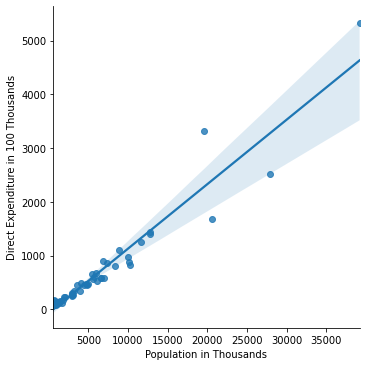

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_jee03['direct_expenditure_100k'] = df_jee03['total_direct_expenditure']/100000
ax = sns.lmplot(data=df_jee03, x="population_k", y="direct_expenditure_100k")
ax.set(xlabel='Population in Thousands', ylabel='Direct Expenditure in 100 Thousands')
plt.show()


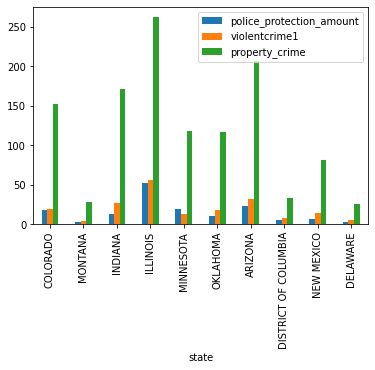

In [63]:
pp_expense_crime_df = mst1_mst2_combine_df.set_index(['state'])
pp_expense_crime_df = pp_expense_crime_df[["police_protection_amount","violentcrime1", "property_crime"]]

# Police protection amount in 100 Thousands
pp_expense_crime_df['police_protection_amount'] = pp_expense_crime_df['police_protection_amount']/100000

# Violent crime and Property Crimes in Thousands
pp_expense_crime_df['violentcrime1'] = pp_expense_crime_df['violentcrime1']/1000
pp_expense_crime_df['property_crime'] = pp_expense_crime_df['property_crime']/1000

pp_expense_crime_df.sample(10).plot.bar()

In [69]:
crime_df = fbi_df.loc[:, (fbi_df.columns != 'state') & (fbi_df.columns != 'population')]
crime_df = crime_df.melt(var_name='source')
crime_df

,source,value
0,violentcrime1,25886.0
1,violentcrime1,5966.0
2,violentcrime1,32583.0
3,violentcrime1,16461.0
4,violentcrime1,174796.0
...,...,...
515,motor_vehicle_theft,9788.0
516,motor_vehicle_theft,32286.0
517,motor_vehicle_theft,2509.0
518,motor_vehicle_theft,9958.0


In [86]:
crime_types = (crime_df.groupby('source')['value'].sum()).to_dict()
crime_types

{'aggravated_assault': 806601.0,
 'burglary': 1523347.0,
 'larceny_theft': 5661618.0,
 'motor_vehicle_theft': 769271.0,
 'murder_and_nonnegligent_manslaughter': 17929.0,
 'property_crime': 7954236.0,
 'rape_legacydefinition3': 95858.0,
 'rape_reviseddefinition2': 130772.0,
 'robbery': 335399.0,
 'violentcrime1': 1290701.0}

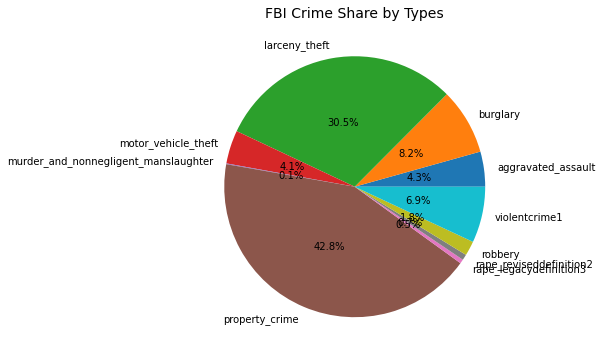

In [87]:
pie, ax = plt.subplots(figsize=[10,6])
labels = list(crime_types.keys())
plt.pie(x=crime_types.values(), autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("FBI Crime Share by Types", fontsize=14);
# plt.pie(crime_df.groupby('source')['value'].sum())

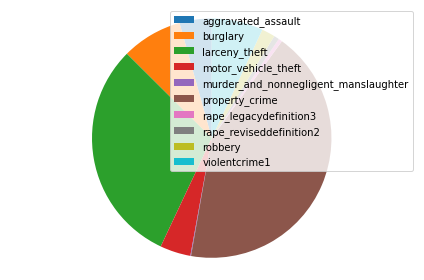

In [88]:
crime_categories = list(crime_types.values())
patches, texts = plt.pie(crime_categories, startangle=90)
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()